In [7]:

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import networkx as nx
from tqdm import tqdm
from PIL import Image
import json
from crp.image import imgify, vis_opaque_img, plot_grid

In [8]:
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs, sample_relevance_cavs, sample_bbox_cavs, sample_all_relevances_cavs
from expbasics.helper import get_attributions, get_model_etc, to_name
from expbasics.visualizations import plot_nmfs
from expbasics.dim_reduction import visualize_dr, get_dr_methods, clean_centroids, centroid_distances


%reload_ext autoreload
%autoreload 2

In [37]:
BIAS = 0.96
NUM_IT = 0
MODEL_NAME = to_name(BIAS, NUM_IT)
model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(BIAS, NUM_IT)


In [38]:
BATCH_SIZE = 4 # 128
N_BASIS = 4
BATCH_STEP_SIZE = 1
NUM_NEIGHBORS = 16
SPATIAL_STEPSIZE = 1#7
CAV_TYPE ="act"
LAYER_NAME = "linear_layers.1"#"convolutional_layers.6" #
# sample activations:
if CAV_TYPE == "act":
    sample_cavs(model, unbiased_ds, LAYER_NAME, SPATIAL_STEPSIZE, BATCH_STEP_SIZE, BATCH_SIZE, MODEL_NAME)
elif CAV_TYPE == "rel":
    sample_relevance_cavs(model, unbiased_ds, LAYER_NAME, SPATIAL_STEPSIZE, BATCH_STEP_SIZE, BATCH_SIZE, crp_attribution, MODEL_NAME)
elif CAV_TYPE == "all":
    sample_all_relevances_cavs(model, unbiased_ds, LAYER_NAME, SPATIAL_STEPSIZE, BATCH_STEP_SIZE, BATCH_SIZE, crp_attribution, MODEL_NAME)
cavs, idx, _ = load_cavs(LAYER_NAME, MODEL_NAME, CAV_TYPE)
H = nmf(cavs, N_BASIS)
H = torch.tensor(H)
print(H.shape)

nn_idx = nearest_neighbors(H, cavs, idx, NUM_NEIGHBORS, "cosine")  # , "cosine"
#for i in range(N_BASIS):
    #vis_nearest_neighbors(unbiased_ds, nn_idx[i], f"{LAYER_NAME}_cosine_{i}")

Computing CAVs:   0%|          | 0/750 [00:00<?, ?batch/s]

Computing CAVs: 100%|██████████| 750/750 [00:01<00:00, 555.15batch/s]


torch.Size([4, 6])


/home/lilli/Desktop/MASTER/code/experiments/expbasics/nmf.py:316: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H = torch.tensor(H, dtype=torch.float32)


In [33]:
cond_layer = "linear_layers.0"  # "convolutional_layers.6"#

t = torch.zeros((N_BASIS, NUM_NEIGHBORS, 64, 64))
told = torch.zeros((N_BASIS, NUM_NEIGHBORS, 64, 64))
originals = torch.zeros((N_BASIS, NUM_NEIGHBORS, 64, 64))
for i in range(N_BASIS):
    for index in range(NUM_NEIGHBORS):
        hold, pred = crp_attribution.heatmap(nn_idx[i][index])
        if CAV_TYPE == "all":
            h = crp_attribution.cav_heatmap(nn_idx[i][index], cond_layer, H[i][16:24])
        elif cond_layer == "linear_layers.0" and CAV_TYPE == "act":
            #h = crp_attribution.cav_heatmap(nn_idx[i][index], cond_layer, H[i][16:24])
            h = crp_attribution.old_cav_heatmap(nn_idx[i][index], cond_layer, H[i])
        else:
            h = crp_attribution.cav_heatmap(nn_idx[i][index], cond_layer, H[i])
        originals[i][index] = crp_attribution.dataset[nn_idx[i][index]][0][0]
        t[i][index] = h
        told[i][index] = hold

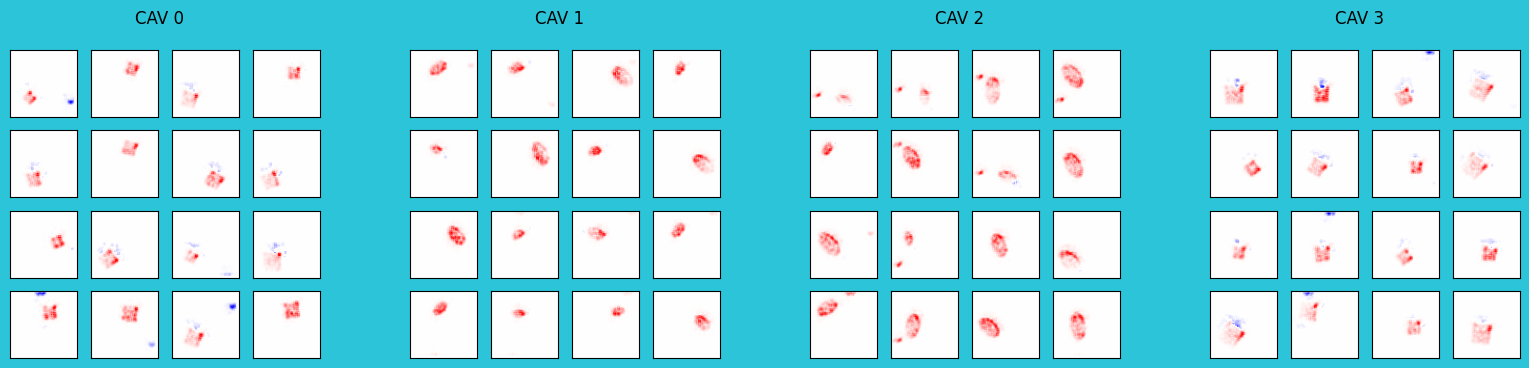

In [36]:
# need real cav attribution again (for all layers)

#plot_nmfs(t, NUM_NEIGHBORS, N_BASIS)

Computing CAVs:   0%|          | 0/750 [03:31<?, ?batch/s]


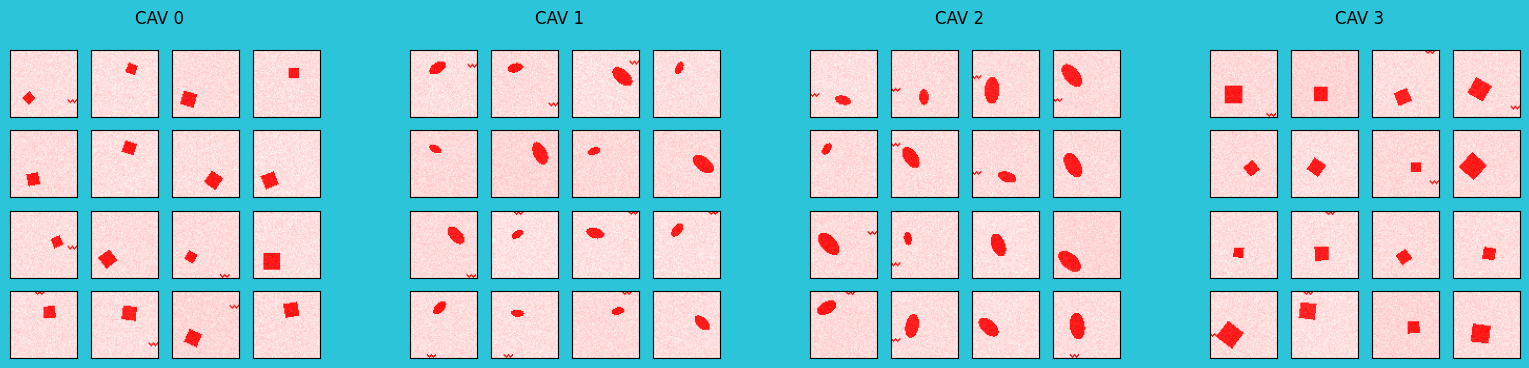

In [34]:
plot_nmfs(originals, NUM_NEIGHBORS, N_BASIS) # NUM_NEIGHBORS, N_BASIS

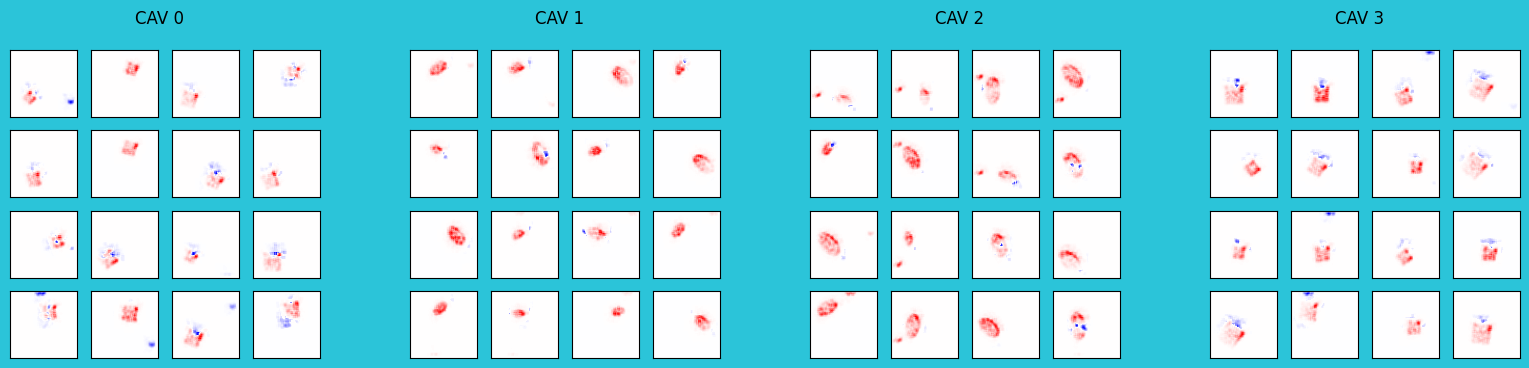

In [35]:
plot_nmfs(told, NUM_NEIGHBORS, N_BASIS)

In [39]:
sample_bbox_cavs(model, LAYER_NAME, crp_attribution, MODEL_NAME)

Computing CAVs:   0%|          | 0/500 [00:00<?, ?img/s]

Computing CAVs: 100%|██████████| 500/500 [00:14<00:00, 33.40img/s]


(array([[-7.33151615e-01, -3.72132897e-01],
        [ 2.28431225e-02, -4.00749356e-01],
        [-3.36597115e-01,  2.84488201e-01],
        [-1.45794019e-01,  2.50256091e-01],
        [ 9.21986976e+01,  3.47129427e+01],
        [ 6.24343693e-01, -5.58453381e-01],
        [-2.91996803e-02,  4.42950368e-01],
        [ 5.45271277e-01,  6.08553290e-01]]),
 array([[-2.26607127e-03, -1.56620413e-03,  3.46446782e-03,
         -1.92612212e-03, -2.14446569e-03, -3.86419566e-03,
          3.68022639e-03, -2.11352226e-03, -1.12017840e-01,
         -7.54463449e-02,  1.38031662e-01, -5.50419278e-02,
         -1.10682085e-01, -2.08385170e-01,  1.71318218e-01,
         -1.06378667e-01, -1.47932395e-03, -2.44897371e-03,
         -2.59786611e-03, -7.35732203e-04, -5.58233878e-04,
         -9.49793088e-04, -1.37409521e-03, -1.07805035e-03,
         -1.22515388e-01, -2.22236291e-01, -2.44440883e-01,
         -6.00619689e-02, -3.90176959e-02, -7.46824667e-02,
         -1.31194666e-01, -9.43375453e-02,  3.

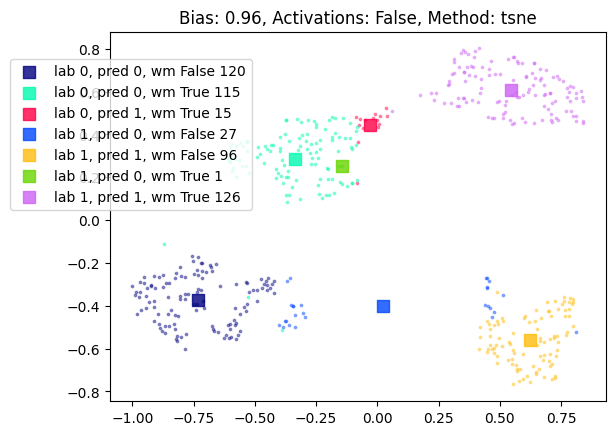

In [40]:
bbox_cavs, idx, infos = load_cavs(LAYER_NAME, MODEL_NAME, "bb")
methods, names = get_dr_methods()

labels = np.array([i[0] for i in infos.values()])
watermarks = np.array([int(i[1]) for i in infos.values()])
preds = np.array([i[2] for i in infos.values()])
visualize_dr(methods, names, bbox_cavs, watermarks, labels, preds, BIAS, False, NUM_IT, 0, LAYER_NAME)


In [45]:
from os import listdir
from os.path import isfile, join
LAYER_NAME = "watermarkbb"
BIASES = list(np.round(np.linspace(0.5, 1.0, 26), 3))
for bias in (pbar := tqdm(BIASES)):
    pbar.set_postfix(
        bias=str(bias),
    )
    for num_it in range(1):
        name = to_name(bias, num_it)
        print(name)
        model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(
            bias, num_it=num_it
        )
        if not isfile(f"outputs/cavs/{LAYER_NAME}_{name}_idx_bb.pt"):
            sample_bbox_cavs(model, LAYER_NAME, crp_attribution, name, disable=True)

  0%|          | 0/26 [00:00<?, ?it/s, bias=0.5]

b0_5-i0


  4%|▍         | 1/26 [00:14<06:13, 14.96s/it, bias=0.52]

b0_52-i0


  8%|▊         | 2/26 [00:30<06:03, 15.14s/it, bias=0.54]

b0_54-i0


 12%|█▏        | 3/26 [00:46<05:59, 15.62s/it, bias=0.56]

b0_56-i0


 15%|█▌        | 4/26 [01:01<05:35, 15.26s/it, bias=0.58]

b0_58-i0


 19%|█▉        | 5/26 [01:19<05:40, 16.22s/it, bias=0.6] 

b0_6-i0


 23%|██▎       | 6/26 [01:39<05:51, 17.56s/it, bias=0.62]

b0_62-i0


 27%|██▋       | 7/26 [01:57<05:38, 17.80s/it, bias=0.64]

b0_64-i0


 31%|███       | 8/26 [02:15<05:23, 17.98s/it, bias=0.66]

b0_66-i0


 35%|███▍      | 9/26 [02:34<05:08, 18.12s/it, bias=0.68]

b0_68-i0


 38%|███▊      | 10/26 [02:53<04:55, 18.45s/it, bias=0.7] 

b0_7-i0


 42%|████▏     | 11/26 [03:11<04:35, 18.36s/it, bias=0.72]

b0_72-i0


 46%|████▌     | 12/26 [03:29<04:16, 18.31s/it, bias=0.74]

b0_74-i0


 50%|█████     | 13/26 [03:48<04:00, 18.48s/it, bias=0.76]

b0_76-i0


 54%|█████▍    | 14/26 [04:07<03:44, 18.67s/it, bias=0.78]

b0_78-i0


 58%|█████▊    | 15/26 [04:26<03:24, 18.59s/it, bias=0.8] 

b0_8-i0


 62%|██████▏   | 16/26 [04:44<03:05, 18.58s/it, bias=0.82]

b0_82-i0


 65%|██████▌   | 17/26 [05:04<02:49, 18.83s/it, bias=0.84]

b0_84-i0


 69%|██████▉   | 18/26 [05:22<02:30, 18.77s/it, bias=0.86]

b0_86-i0


 73%|███████▎  | 19/26 [05:42<02:13, 19.01s/it, bias=0.88]

b0_88-i0


 77%|███████▋  | 20/26 [06:00<01:52, 18.78s/it, bias=0.9] 

b0_9-i0


 81%|████████  | 21/26 [06:19<01:34, 18.91s/it, bias=0.92]

b0_92-i0


 85%|████████▍ | 22/26 [06:40<01:17, 19.48s/it, bias=0.94]

b0_94-i0


 88%|████████▊ | 23/26 [07:00<00:58, 19.58s/it, bias=0.96]

b0_96-i0


 92%|█████████▏| 24/26 [07:20<00:39, 19.69s/it, bias=0.98]

b0_98-i0


 96%|█████████▌| 25/26 [07:40<00:19, 19.79s/it, bias=1.0] 

b1_0-i0


100%|██████████| 26/26 [08:01<00:00, 18.51s/it, bias=1.0]


  0%|          | 0/26 [00:00<?, ?it/s, num_it=0]

100%|██████████| 26/26 [01:40<00:00,  3.88s/it, num_it=3] 


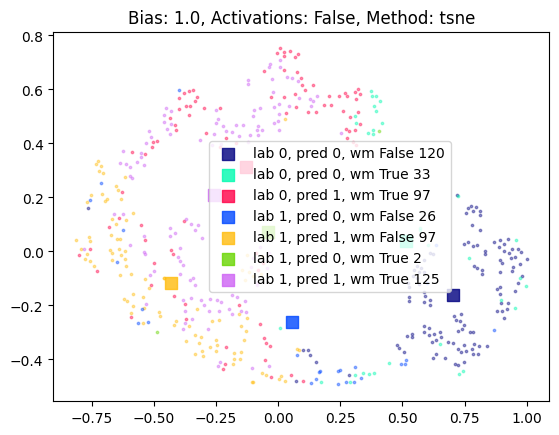

In [46]:
methods, names = get_dr_methods()
all_centroids = {}
concept_means = {}
BIASES = list(np.round(np.linspace(0.5, 1.0, 26), 3))

for bias in (pbar := tqdm(BIASES)):
    pbar.set_postfix(
        bias=str(bias),
    )
    for num_it in range(4):
        pbar.set_postfix(
            num_it=str(num_it),
        )
        name = to_name(bias, num_it)
        bbox_cavs, idx, infos = load_cavs(LAYER_NAME, name, "bb")
        if len(idx) < 1:
            print("no data")

        labels = np.array([i[0] for i in infos.values()])
        watermarks = np.array([int(i[1]) for i in infos.values()])
        preds = np.array([i[2] for i in infos.values()])
        centroids, full_centroids = visualize_dr(
            methods,
            names,
            bbox_cavs,
            watermarks,
            labels,
            preds,
            bias,
            False,
            num_it,
            0,
            "bbox_rels",
        )
        all_centroids[str(bias)] = full_centroids
        concept_means[name] = full_centroids.tolist()

with open("outputs/bbox_cavs_centroids.json", "w") as f:
    json.dump(concept_means, f, indent=2)

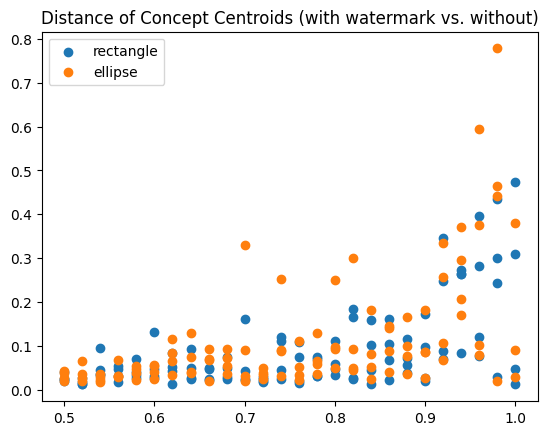

In [56]:
concepts_named = clean_centroids(concept_means)
biases = [b for b  in BIASES  for i in range(4)]

res = centroid_distances(concepts_named, biases)

/home/lilli/Desktop/MASTER/code/experiments/expbasics/dim_reduction.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  if res[d, 0].shape[0] > 0:


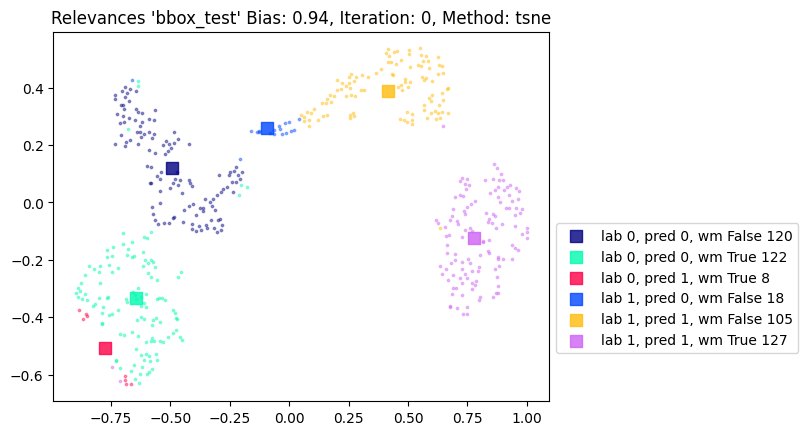

In [89]:
extrab, extran = 0.94, 0
name = to_name(extrab, extran)

bbox_cavs, idx, infos = load_cavs(LAYER_NAME, name, "bb")
if len(idx) < 1:
    print("no data")

labels = np.array([i[0] for i in infos.values()])
watermarks = np.array([int(i[1]) for i in infos.values()])
preds = np.array([i[2] for i in infos.values()])
centroids, full_centroids = visualize_dr(
    methods,
    names,
    bbox_cavs,
    watermarks,
    labels,
    preds,
    extrab,
    False,
    extran,
    0,
    "bbox_test",
    #use_clusters=True
)